# Imports

In [20]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, StringLookup

# Setups

In [21]:
CHARS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
WIDTH = 200
HEIGHT = 50

In [22]:
# Mapping characters to integers
char_to_num = StringLookup(vocabulary=CHARS)

# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
)

# Utility Functions

In [23]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [24]:
def read_dataset(directory):
    data_dir = Path(directory)
    images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
    labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
    return images, labels

In [25]:
def preprocess_image(img_path, to_gray):
    img = tf.io.read_file(img_path)
    if to_gray:
        img = tf.io.decode_png(img, channels=1)
    else:
        img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [HEIGHT, WIDTH])
    if to_gray:
        img = tf.transpose(img, perm=[1, 0, 2])
    return img

In [26]:
# Get the prediction model by extracting layers till the output layer
def get_predictor_models(model_path):
    model = load_model(
        model_path,
        custom_objects={'CTCLayer': CTCLayer}
    )

    predictor_model = Model(
        model.get_layer(name="image").input,
        model.get_layer(name="Dense2").output
    )

    return predictor_model

In [27]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred, max_length):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(
        pred,
        input_length=input_len,
        greedy=True
    )[0][0][:, :max_length]

    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        res = res.replace('[UNK]', 'x')
        output_text.append(res)
    return output_text

In [28]:
def predict_single_path(path, label=None):
    img = preprocess_image(path, to_gray=False)
    img_batch = np.expand_dims(img, axis=0)

    img_class = cls_model.predict(img_batch)
    img_class = np.argmax(img_class)

    img = preprocess_image(path, to_gray=True)
    img_batch = np.expand_dims(img, axis=0)

    if label:
        if len(label) == 10:
                img_class = 1
        else:
                img_class = 0

    # National card
    if img_class == 1:
        pred_class = 'National'
        pred = nat_model.predict(img_batch)
        pred_text = decode_batch_predictions(pred, 10)
        
    # Credit card
    else:
        pred_class = 'Credit'
        pred = cred_model.predict(img_batch)
        pred_text = decode_batch_predictions(pred, 16)

    return pred_class, pred_text[0]

In [29]:
def single_file_show(path, label):
    from PIL import Image
    img_raw = np.asarray(Image.open(path))
    plt.imshow(img_raw)
    plt.axis("off")
    plt.show()

    pred_class, pred_label = predict_single_path(path, label)
    print(f'Pred Class: {pred_class}')
    print(f'Pred Label: {pred_label}')
    print(f'True Label: {label}')

In [30]:
def predict_folder(folder_path):
    images, labels = read_dataset(folder_path)
    batch_size = len(images)

    total_digits = 0
    wrong_digits = 0

    for i in range(batch_size):
        path = images[i]
        label = labels[i]
        label_len = len(label)

        pred_class, pred_label = predict_single_path(path, label)

        if label_len == 10:
            true_class = 'National'
        else:
            true_class = 'Credit'

        total_digits += label_len
        if true_class != pred_class:
            wrong_digits += label_len
        else:
            for j in range(label_len):
                if label[j] != pred_label[j]:
                    wrong_digits += 1

        print(f'Pred Class: {pred_class}')
        print(f'Pred Label: {pred_label}')
        print(f'True Label: {label}')
        print('-----------------------')

    print(f'Accuracy: {(total_digits - wrong_digits) / total_digits}')

# Download model and test sets

In [31]:
!gdown --id 1rnqjpz8MJb4PbDWY9biFVuPeCtce3PVN
classifier_path = './classifier_model.hdf5'

!gdown --id 1zaOuXFbm5xMrgrR-ML54JRTM_zg-UkgH
credit_model_path = './credit_model.hdf5'

!gdown --id 1I5Z-MItxv15ajZehBKEzD2HJ0beIZUqt
national_model_path = 'national_model.hdf5'

Downloading...
From: https://drive.google.com/uc?id=1rnqjpz8MJb4PbDWY9biFVuPeCtce3PVN
To: /content/classifier_model.hdf5
100% 7.16M/7.16M [00:00<00:00, 33.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zaOuXFbm5xMrgrR-ML54JRTM_zg-UkgH
To: /content/credit_model.hdf5
100% 5.31M/5.31M [00:00<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I5Z-MItxv15ajZehBKEzD2HJ0beIZUqt
To: /content/national_model.hdf5
100% 5.31M/5.31M [00:00<00:00, 75.6MB/s]


In [32]:
# Fake Tests
!gdown --id 1K82kQG5Vkj987Mo6AXMl36BRh9-GGoIK
!unzip -qq -n tests_fake.zip
!rm tests_fake.zip

Downloading...
From: https://drive.google.com/uc?id=1K82kQG5Vkj987Mo6AXMl36BRh9-GGoIK
To: /content/tests_fake.zip
100% 203k/203k [00:00<00:00, 44.6MB/s]


In [33]:
# Real Tests
!gdown --id 1KfKRWFktOjwkPnKwBg2gxTcoh3DImN2c
!unzip -qq -n tests_real.zip
!rm tests_real.zip

Downloading...
From: https://drive.google.com/uc?id=1KfKRWFktOjwkPnKwBg2gxTcoh3DImN2c
To: /content/tests_real.zip
100% 82.6k/82.6k [00:00<00:00, 83.2MB/s]


# Evaluating

In [34]:
cls_model = load_model(classifier_path)
cred_model = get_predictor_models(credit_model_path)
nat_model = get_predictor_models(national_model_path)

In [35]:
folder_path = 'tests_fake'
predict_folder(folder_path)

Pred Class: Credit
Pred Label: 0280794529230760
True Label: 0380794529239760
-----------------------
Pred Class: Credit
Pred Label: 0670025439496922
True Label: 0670025439496922
-----------------------
Pred Class: Credit
Pred Label: 073688064400678x
True Label: 0736560613000678
-----------------------
Pred Class: National
Pred Label: 1077705983
True Label: 1077705983
-----------------------
Pred Class: Credit
Pred Label: 1486784975304333
True Label: 1486784975304333
-----------------------
Pred Class: National
Pred Label: 2273123026
True Label: 2273123026
-----------------------
Pred Class: National
Pred Label: 2406761144
True Label: 2406761144
-----------------------
Pred Class: National
Pred Label: 2466197563
True Label: 2466197563
-----------------------
Pred Class: National
Pred Label: 2566160658
True Label: 2566160658
-----------------------
Pred Class: Credit
Pred Label: 3425396164914365
True Label: 3425396164914365
-----------------------
Pred Class: Credit
Pred Label: 367475701

In [36]:
folder_path = 'tests_real'
predict_folder(folder_path)

Pred Class: National
Pred Label: 0006165591
True Label: 0006165591
-----------------------
Pred Class: National
Pred Label: 0006657184
True Label: 0006657184
-----------------------
Pred Class: National
Pred Label: 0022785418
True Label: 0022785418
-----------------------
Pred Class: National
Pred Label: 6161266621
True Label: 0067062571
-----------------------
Pred Class: National
Pred Label: 1234567890
True Label: 1234567890
-----------------------
Pred Class: Credit
Pred Label: 6556612292212225
True Label: 6037991165316294
-----------------------
Pred Class: Credit
Pred Label: 4217822208656278
True Label: 6037993249885617
-----------------------
Pred Class: Credit
Pred Label: 546923794256651x
True Label: 6104337018560571
-----------------------
Pred Class: Credit
Pred Label: 7622146106984365
True Label: 6221061069843656
-----------------------
Accuracy: 0.47368421052631576


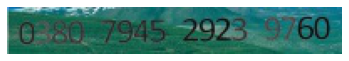

Pred Class: Credit
Pred Label: 0280794529230760
True Label: 0380794529239760


In [37]:
path = 'tests_fake/0380794529239760.jpg'
label = '0380794529239760'
single_file_show(path, label)